# Fake news detection

**Authors:** Peter Mačinec, Simona Miková

## Configuration and reading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re 

from nltk.tokenize import sent_tokenize 
from langdetect import detect as lang_detect

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
df = pd.read_json('../data/raw/dataset.json', orient='index')

In [4]:
len(df)

195764

## Descriptive analysis of dataset

At first, let's have a look at data:

In [5]:
df.head()

,author,body,id,image,label,perex,source,title
235036,Mike Adams,(NaturalNews) The United States government cla...,235036,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,<p>(NaturalNews) The United States government ...,naturalnewsblogs.com,US government claims 100% ownership over all y...
235037,by Ronica O&rsquo;Hara (info@www.naturalawaken...,DIGITAL KIDS: How to Click With Young Techies\...,235037,http://www.naturalawakeningsmag.com/Healthy-Ki...,unreliable,Many Silicon Valley executives that design dev...,naturalawakeningsmag.com,DIGITAL KIDS: How to Click With Young Techies
235038,by Kathleen Gould and Madalyn Johnson (info@ww...,Herbs: Nature’s Fountain of Youth\n\nby Kathle...,235038,http://www.naturalaz.com/ARIZ/September-2019/H...,unreliable,It seems aging is a two-edge sword. At the sam...,naturalawakeningsmag.com,Herbs: Nature’s Fountain of Youth
235039,Mike Adams,(NaturalNews) Beyond merely inspiring women to...,235039,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,<p>(NaturalNews) Beyond merely inspiring women...,naturalnewsblogs.com,Angelina Jolie copied by men! Surgeons now cut...
235040,by Andrea Purcell (info@www.naturalawakeningsm...,Give Your Brain a Boost\n\nby Andrea Purcell\n...,235040,http://www.naturalaz.com/ARIZ/September-2019/G...,unreliable,"In the United States, there are currently 9.4 ...",naturalawakeningsmag.com,Give Your Brain a Boost


Some statistics for each column:

In [6]:
df.describe(exclude=[np.number])

,author,body,image,label,perex,source,title
count,194880,195560,165907,193951,174427,195764,195764
unique,5195,182501,134343,2,159132,119,178276
top,Neuroscience News Posts Science Research News ...,\nbody.page-template-default .section-title { ...,https://www.statnews.com/wp-content/uploads/20...,unreliable,<p>Log In Enter your username and password bel...,naturalnews.com,Up and down the ladder: The latest comings and...
freq,12941,953,950,156341,605,20452,136


Are there any missing values?

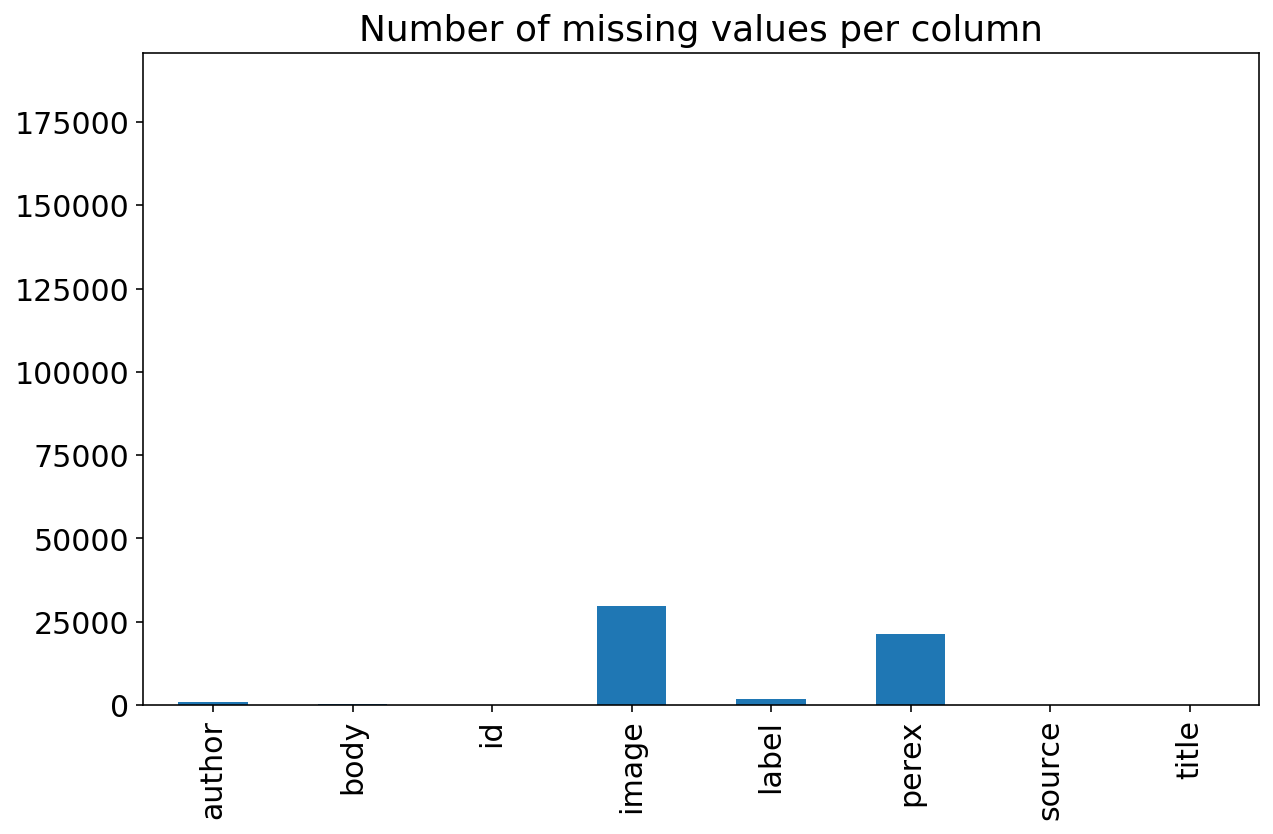

In [7]:
df.isnull().sum().plot(
    kind='bar',
    title='Number of missing values per column',
    ylim=(0, len(df))
);

There are some missing values in certain columns. We don't plan to use many of these values for now, so we will deal with them later in preprocessing by dropping them.

Let's see atricles distribution per individual sources:

In [8]:
df.source.value_counts()[:10]

naturalnews.com         20452
naturalnewsblogs.com    17755
neurosciencenews.com    13050
statnews.com            12109
hsionline.com            8147
naturalsociety.com       7348
healthnutnews.com        7149
healthimpactnews.com     6232
infowars.com             6009
zemavek.sk               5337
Name: source, dtype: int64

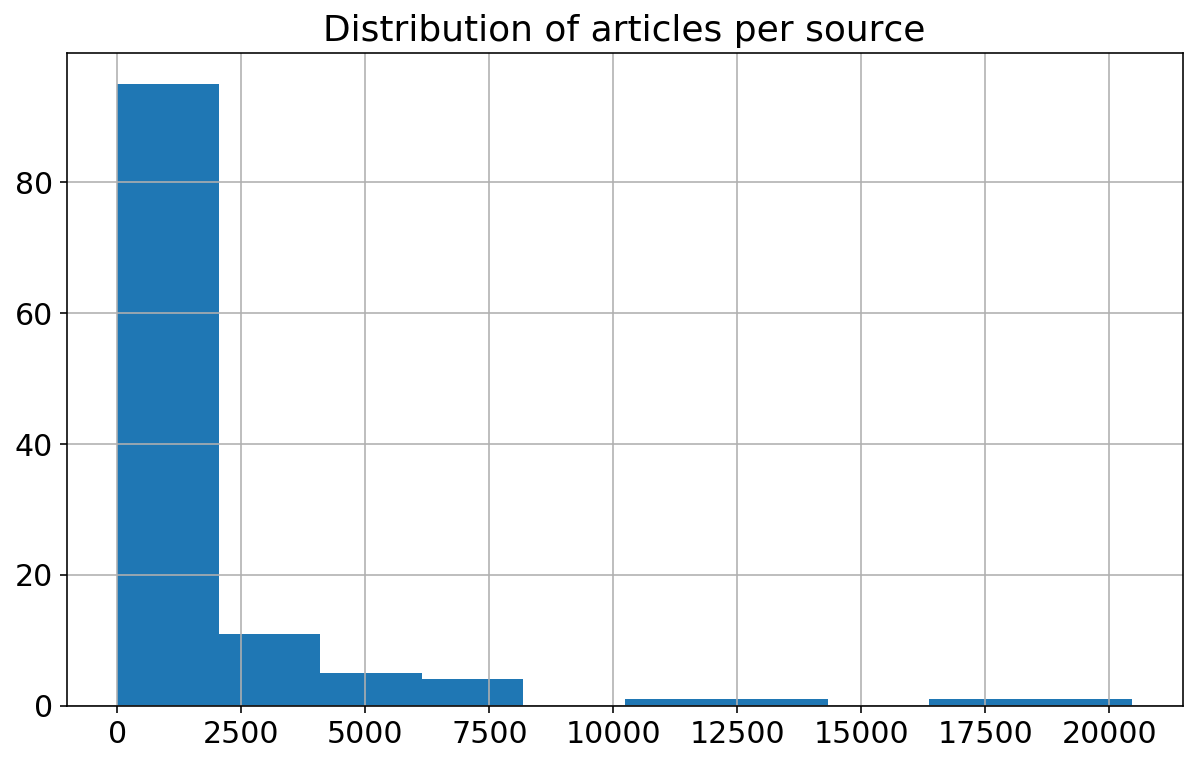

In [9]:
df.source.value_counts().hist();
plt.title('Distribution of articles per source');

From chart above, we can see there are some sources with significantly higher number of articles than others (naturalnews.com, naturalnewsblog.com, etc.).

Finally, let's have a look if label column is balanced.

In [10]:
df.label.value_counts()

unreliable    156341
reliable       37610
Name: label, dtype: int64

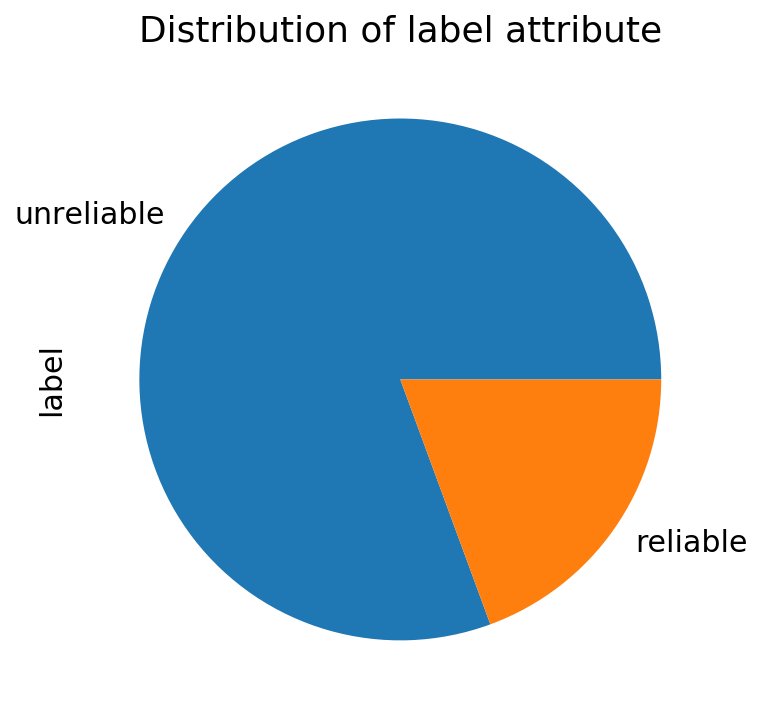

In [11]:
df.label.value_counts().plot(kind='pie', title='Distribution of label attribute');

Values are quite unbalanced, we will need to balance them after preprocessing to avoid overfiting of one class. 

In [12]:
df.dropna(subset=['body'], inplace=True)

### Quick look at data 

While going through articles, we found some groups of articles with following content:

In [13]:
df.loc[332309].body[:1000]

'Cannabis is a Schedule I drug in the United States. By definition that means two\xa0agencies within the federal government, the DEA and the FDA, have designated the plant as having no accepted medical use and a high potential for abuse.\nDespite no deaths caused by cannabis sativa to date, due to the federal scheduling it is resultantly lumped into the same category as:\nHeroin (diacetylmorphine)Mescaline (Peyote)MDMA (3,4-methylenedioxymethamphetamine aka ecstasy)LSD (Lysergic acid diethylamide)Psilocybin\nCannabis has no medical use? Countless studies say otherwise…\nIf you are unfamiliar with Rick Simpson\xa0and his work treating cancer and providing the recipe for free, or want to know more, go here. Cancer is only one of many ailments that this profoundly interesting plant can treat or alleviate completely. Many people are having success switching to cannabis for their pain and getting off of liver and kidney-destroying pills for instance. To stay up-to-date on information regard

In [14]:
df.loc[332309].body[6000:]

'.gov/pubmed/18354058http://www.ncbi.nlm.nih.gov/pubmed/19189054http://www.ncbi.nlm.nih.gov/pubmed/17934890http://www.ncbi.nlm.nih.gov/pubmed/16571653http://www.ncbi.nlm.nih.gov/pubmed/19889794http://www.ncbi.nlm.nih.gov/pubmed/15361550\nTranslocation-positive rhabdomyosarcoma\nhttp://www.ncbi.nlm.nih.gov/pubmed/19509271\nLymphoma\nhttp://www.ncbi.nlm.nih.gov/pubmed/18546271http://www.ncbi.nlm.nih.gov/pubmed/16936228http://www.ncbi.nlm.nih.gov/pubmed/16337199http://www.ncbi.nlm.nih.gov/pubmed/19609004\nCannabis kills cancer cells\nhttp://www.ncbi.nlm.nih.gov/pubmed/16818634http://www.ncbi.nlm.nih.gov/pubmed/12648025http://www.ncbi.nlm.nih.gov/pubmed/17952650http://www.ncbi.nlm.nih.gov/pubmed/16835997\nMelanoma\nhttp://www.ncbi.nlm.nih.gov/pubmed/17065222\nThyroid carcinoma\nhttp://www.ncbi.nlm.nih.gov/pubmed/18197164\nColon cancer\nhttp://www.ncbi.nlm.nih.gov/pubmed/18938775http://www.ncbi.nlm.nih.gov/pubmed/19047095\nIntestinal inflammation and cancer\nhttp://www.ncbi.nlm.nih.gov/pubm

The end of these articles contains mostly url lists without any valuable information, so we don't want to use such data in training. At the same time, we don't want to lose the usable data contained in the article and therefore don't want to delete all of the articles. As a solution, we will remove the urls from the end of the article without losing the entire article data.

In [15]:
df['body'] = df.apply(
    lambda x: re.sub(r'(www|http:|https:)+[^\s]+[\w]', '', x['body']),
    axis=1
)

Second group contains CDATA section at the end:

In [16]:
df.loc[307550].body[600:]

'at CO exposure appeared to have a slight narcotic effect. And the effect was enough to lower stress levels caused by noise and large crowds.\nOf course, it’s impossible to regulate your exposure to outdoor CO. And needless to say, you wouldn’t want to take steps to increase CO exposure.\nBut the researchers also found that urban stress drops as noise pollution decreases.\nHmmm… Good luck asking city slickers if they could just keep it down a little.\nSources:\n“Carbon Monoxide — The Silent Calmer?” American Friends / Tel Aviv University, 11/8/11, aftau.org\nGet urgent health alerts, warnings and insights delivered straight to your inbox\n\n\n\t\t\t<!--//<![CDATA[\n\t\t\t   var m3_u = (location.protocol==\'\');\n\t\t\t   var m3_r = Math.floor(Math.random()*99999999999);\n\t\t\t   if (!document.MAX_used) document.MAX_used = \',\';\n\t\t\t   document.write ("<scr"+"ipt src=\'"+m3_u);\n\t\t\t   document.write ("?zoneid=28");\n\t\t\t   document.write (\'&amp;cb=\' + m3_r);\n\t\n\t\t\t   if

We will remove this section from articles as well.

In [17]:
df['body'] = df.apply(
    lambda x: re.sub(r'<!--\/\/\<\!\[CDATA\[[^\]]*\]\]\>-->', '', x['body']),
    axis=1
)

### Duplicates

Now let's check if there are some duplicates.

In [18]:
len(df[df.duplicated(['body'])])

13073

Let's have a look at some of them: 

In [19]:
df[df.duplicated(['body'])].head(7)

,author,body,id,image,label,perex,source,title
235419,Arjun Walia,How many times have you come across a ‘natural...,235419,None,unreliable,How many times have you come across a &#8216;n...,collective-evolution.com,Oil Pulling For Oral Health: What The Research...
235838,Robert F. Kennedy Jr.,A new study published in Clinical Rheumatology...,235838,None,unreliable,A new study published in Clinical Rheumatology...,collective-evolution.com,New Study Finds A “Wide Range of Devastating R...
235901,Arjun Walia,Below is a clip from an interview we recently ...,235901,None,unreliable,Below is a clip from an interview we recently ...,collective-evolution.com,Why Harvard Medical School Has One Of The Larg...
236046,Arjun Walia,Artificial sweeteners have been a controversia...,236046,None,unreliable,Artificial sweeteners have been a controversia...,collective-evolution.com,"Artificially Sweetened Drinks (Aspartame, etc...."
236052,Alanna Ketler,There is so much to say about this widely used...,236052,None,unreliable,A psychiatrist gives his insight on just how t...,collective-evolution.com,This Psychiatrist’s Take On Alcohol May Make Y...
236114,Arjun Walia,When it comes to the most widely used adjuvant...,236114,None,unreliable,When it comes to the most widely used adjuvant...,collective-evolution.com,New In Vivo Studies Find Most Common Vaccine I...
236159,Arjun Walia,"* Please be advised that there are multiple, h...",236159,None,unreliable,"* Please be advised that there are multiple, h...",collective-evolution.com,The Heart Disease Rates of Meat-Eaters Versus ...


We don't need duplicated data, so we can drop them. 

In [20]:
df.drop_duplicates(subset=['body'], inplace=True)

In [21]:
len(df)

182487

### Word count per atricle

It can be interesting to see number of words per atricle. At least it can help us to find out some problems in text.

In [22]:
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

In [23]:
df[['body','word_count']].head()

,body,word_count
235036,(NaturalNews) The United States government cla...,982
235037,DIGITAL KIDS: How to Click With Young Techies\...,719
235038,Herbs: Nature’s Fountain of Youth\n\nby Kathle...,776
235039,(NaturalNews) Beyond merely inspiring women to...,1280
235040,Give Your Brain a Boost\n\nby Andrea Purcell\n...,515


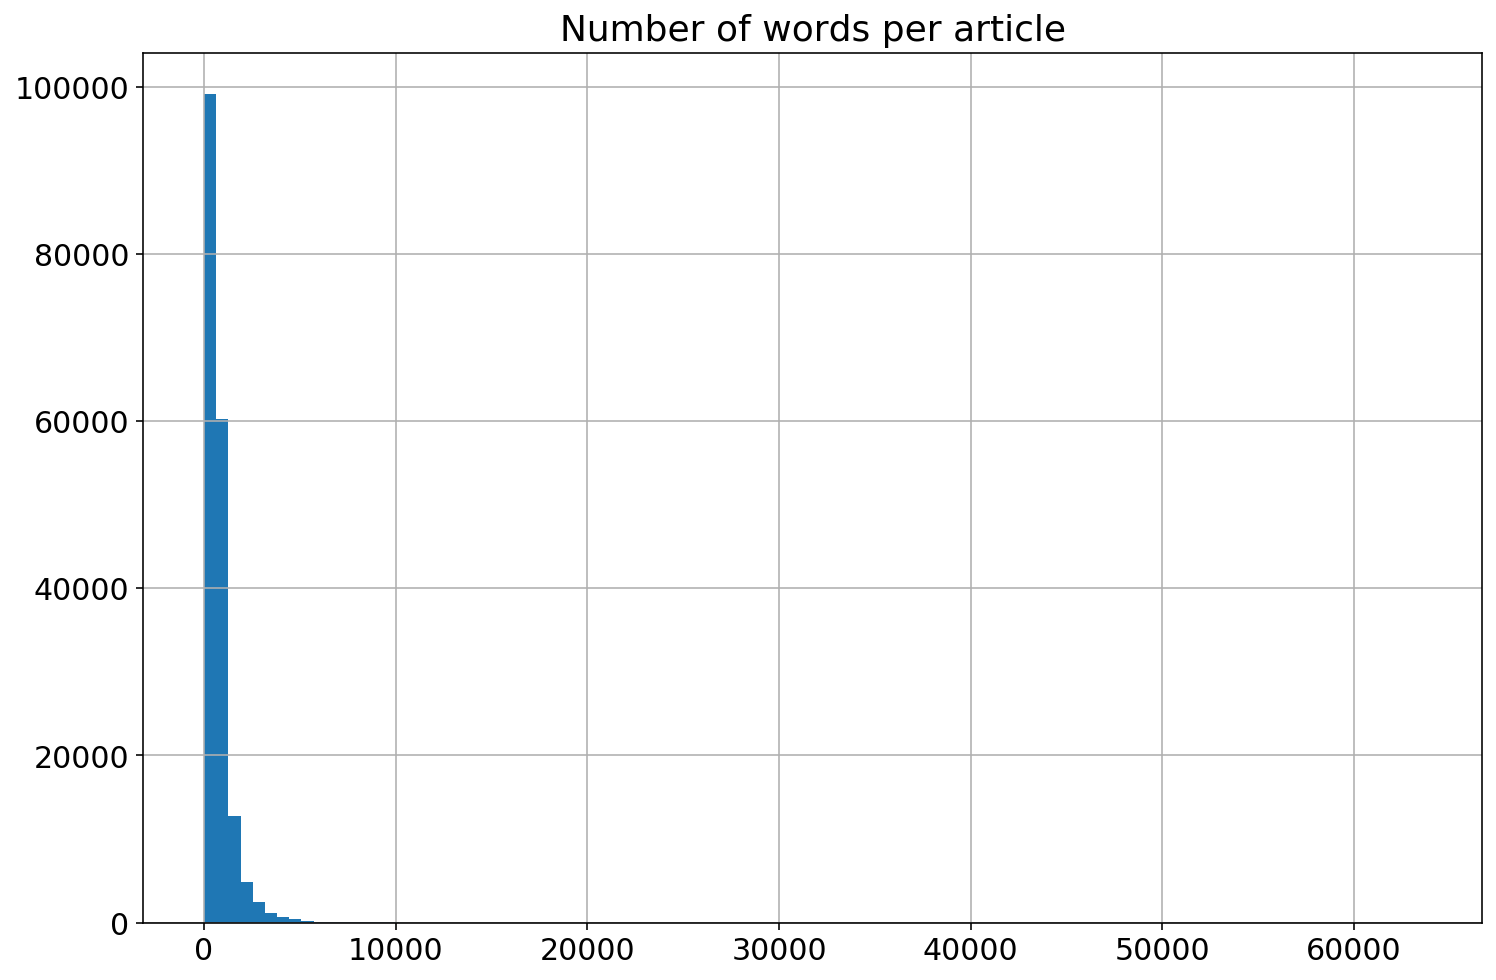

In [24]:
df.hist(column='word_count', bins=100, figsize=(12,8))
plt.title('Number of words per article');

Arcicles with least number of words can be interesting:

In [25]:
df.word_count.sort_values(ascending= True)[:1000]

428783     0
326832     0
326879     0
340877     0
327481     0
          ..
365259    29
383156    29
290427    29
287963    29
330576    30
Name: word_count, Length: 1000, dtype: int64

Let's have a look at some of these articles.

In [26]:
df.loc[358228].body # word_count 28

'These little round scones are a softer and chewier adaptation of oatcakes, a traditional Scottish hard crackers or biscuits that are served with jam, dip or on their own.\n'

In [27]:
df.loc[267076].body # word_count 56

'After the ASCO weekend, cancer drug stocks are moving. Here are your winners and losers\n\nUpdated at 11:33 am ET with new information and stock prices.\n\nInvestors spent the weekend chewing over cancer drug data presented at the American Society of Clinical Oncology annual meeting. It’s Monday, so time to see how the markets are reacting.'

In [28]:
df.loc[271949].body # word_count 80

'Startup Spotlight: Finding a better way to open cells to CRISPR\n\nThere are many ways to get CRISPR into a cell. Viruses will do the trick. Squeezing a cell will also work. A surge of electricity can also open up pores in a cell’s membrane. So some companies — anticipating an impending genome-editing gold rush — are setting up shop to sell these proverbial picks and shovels for the next generation of therapies.\n\nOne of those companies is Indee Labs.'

In [29]:
df.loc[270164].body # word_count 103

'Biotech execs still fret about pressure to bring down drug prices — but fears are starting to ease\n\nBiotech executives appear slightly less concerned about drug pricing than in the recent past, according to a new analysis, but the continued pressure from payers and lawmakers to bring down costs does still weigh on them.\n\nA review of risk factors cited by the 100 largest companies listed in the Nasdaq Biotechnology Index found 84 percent cited worries over pricing pressures, according to the BDO advisory and consulting firm, which examined the most recent crop of annual filings with the US Securities and Exchange Commission.'

These articles are rather short messages or statements, which is not so valuable for us. Articles start to gain value at about 100 words upwards, so we will set limit for the shortest article to 100 words.


What about the longest articles?

In [30]:
df.word_count.sort_values(ascending=False)[:250]

394340    63519
326834    52845
323994    29336
285747    27422
258505    19554
          ...  
257486     6578
327002     6572
278782     6571
371389     6570
261651     6568
Name: word_count, Length: 250, dtype: int64

There are some articles with very high values of number of words. 

In [31]:
df.loc[394340].body[:500] # word_count 63520

'\n\n\n\n\n\n\n3  OHŘÍVAČE\n\nSRPEN – VLÁDNOU  NÁM  3  OHŘÍVAČE\n\n3D\n\nDVOJPLAMENNÁ  CESTA\n\n4D\n\n12 ČAKER\n\n5D\n\n12 ČAKER\n\n7 podob\n\n7 PODOB  LÁSKY  A  7  ČAKER\n\n7 čaker\n\n7 PODOB  LÁSKY  A  7  ČAKER\n\nAB\n\nKREVNÍ SKUPINA AB\n\nABSCES\n\nBYLINKY NA  KOŽNÍ  NEMOCI  A  RÁNY\n\nABSTINENCE\n\nPŘÍČINY  VZNIKU  ZÁVISLOSTÍ  JSOU  JINÉ,  NEŽ  SI  MYSLÍME\n\nABSTINENČNÍ  PŘÍZNAKY\n\nDETOXIKACE  TRÁVICÍHO  ÚSTROJÍ  A  ODSTRANĚNÍ  NIKOTINU  Z  TĚLA\n\nABSŤÁK\n\nJAK  SE  ZBAVIT  ZÁVISLOSTI  NA  CUKRU  DO  10TI  DNŮ\n\nACYLPYRIN\n\nJAK  NA  BOLES'

This is just an overview of terms or some glossary.

In [32]:
df.loc[258505].body[:500] # word_count 19554

'\nBetrayal of Public Trust & Institutional Corruption: Vaccine Safety Ratings & Vaccine Science Falsified\nby Vera Sharav\nAlliance for Human Research Protection\nAPPENDIX 9: of\xa0 L’Affaire Wakefield: Shades of Dreyfus\xa0\xa0(Dr. Andrew Wakefield: Fraud or Scapegoat?)\n[Fully referenced pdf copy of Appendix 9]\n\nThe exponential increase in the autism/autism spectrum prevalence rate since 1985 (1 in 2,500) to (1 in 45) in 2916, is evidence of an epidemic, not, as the deniers will have it, “an optical illusio'

By quickly analyzing these longest articles and common articles at popular news sites, we have concluded that it is logical to set a threshold for the longest article to 6000 words.


In [33]:
df = df.loc[(df['word_count'] > 100) & (df['word_count'] < 6000)]

In [34]:
len(df)

174364

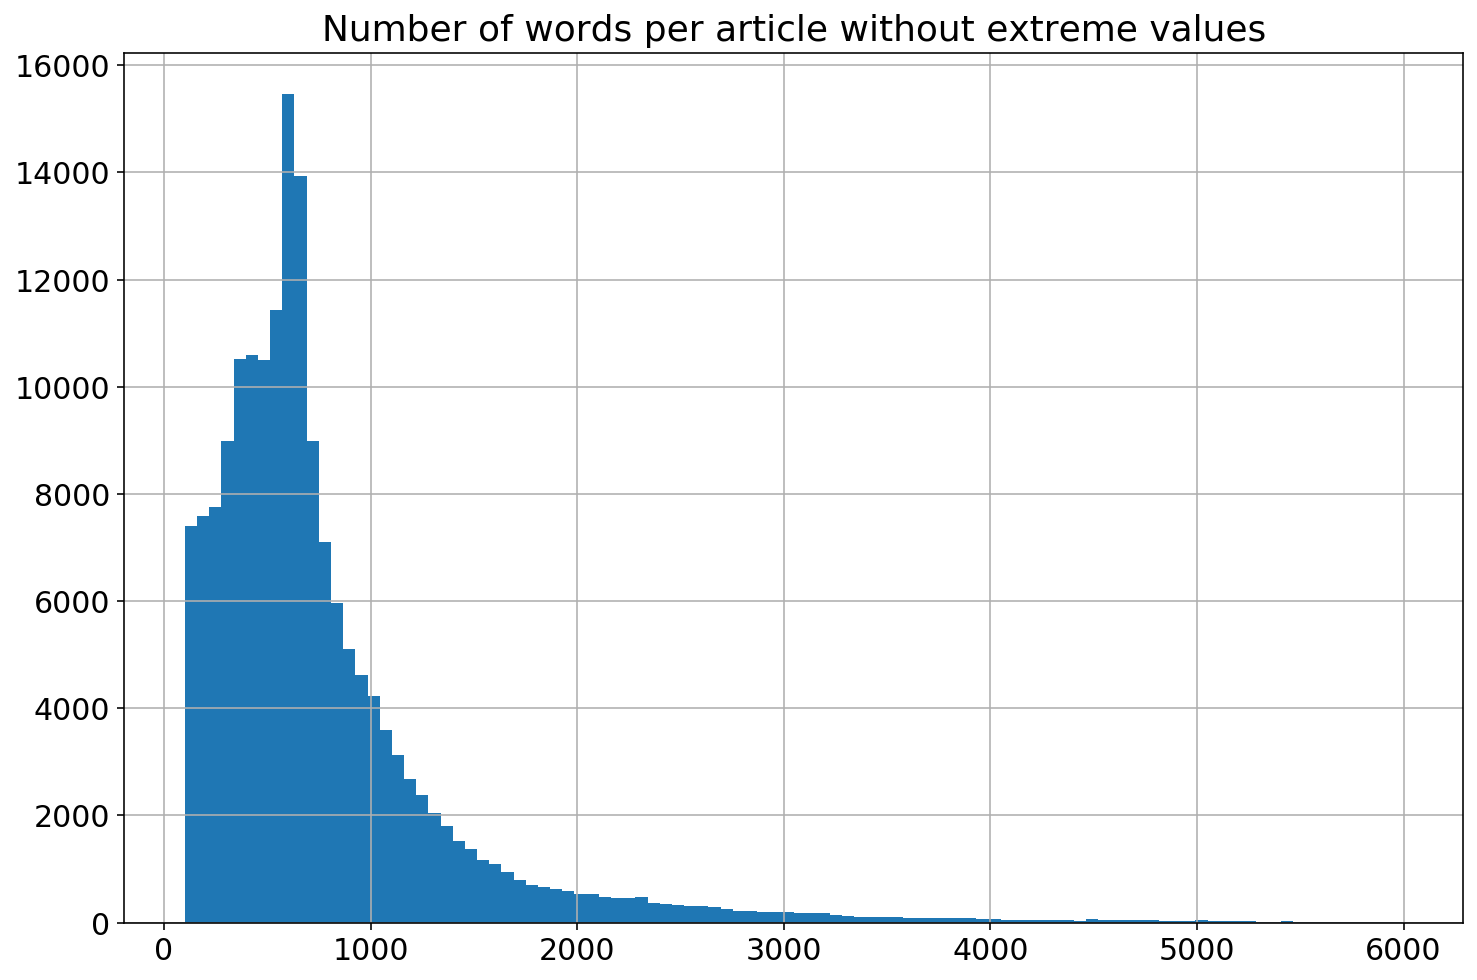

In [35]:
df.hist(column='word_count', bins=100, figsize=(12,8))
plt.title('Number of words per article without extreme values');

Article lenght is now more evenly distributed.

### Average sentence length per article

Average number of words in senetence can help us further analyze the content of articles.

In [36]:
def get_sentence_tokens(text):
    result = re.sub(r'\w\n', '. ', text)
    result = re.sub(r'\.{2,}', '. ', result)
    result = re.sub(r'\.', '. ', result)

    return sent_tokenize(result)

In [37]:
df['avg_sentence_length'] = df.apply(
    lambda x: x['word_count'] / len(get_sentence_tokens(x['body'])),
    axis=1
)

In [38]:
df[['body', 'avg_sentence_length']].head()

,body,avg_sentence_length
235036,(NaturalNews) The United States government cla...,19.640000
235037,DIGITAL KIDS: How to Click With Young Techies\...,17.119048
235038,Herbs: Nature’s Fountain of Youth\n\nby Kathle...,15.215686
235039,(NaturalNews) Beyond merely inspiring women to...,15.058824
235040,Give Your Brain a Boost\n\nby Andrea Purcell\n...,12.560976


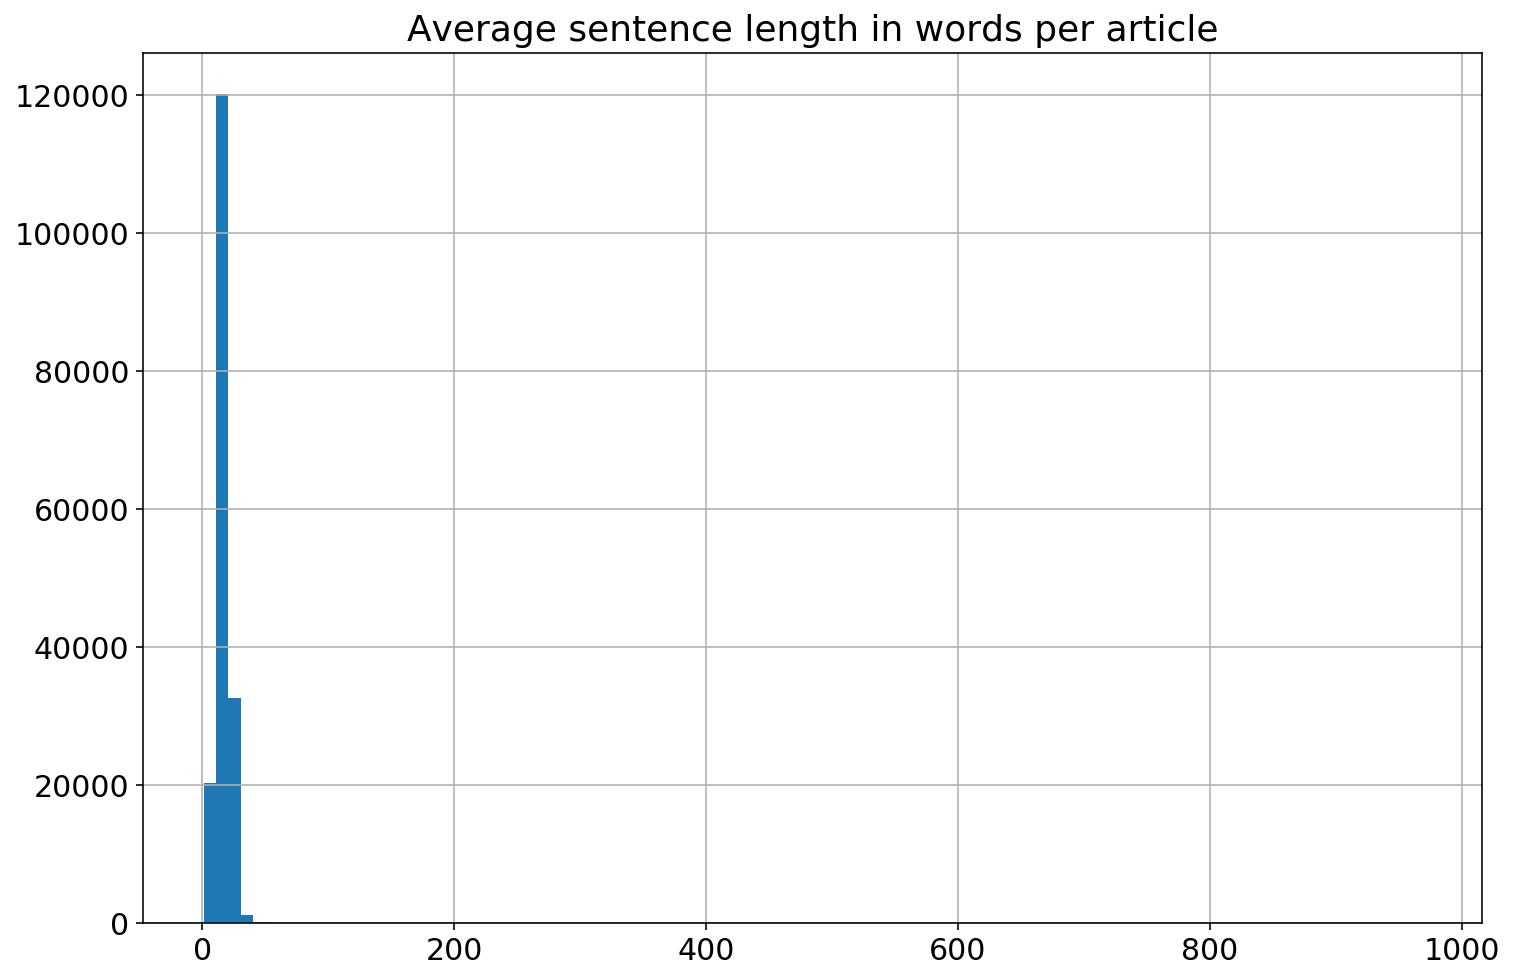

In [39]:
df.hist(column='avg_sentence_length', bins=100, figsize=(12,8))
plt.title('Average sentence length in words per article');

Let's have a look at minimum and maximum values and some articles: 

In [40]:
df.avg_sentence_length.sort_values(ascending= True)[:500]

287735    1.443956
394348    1.605960
333560    1.620155
307313    1.620482
392369    1.707071
            ...   
409291    5.093750
267595    5.098592
391649    5.098765
411920    5.098765
407911    5.102564
Name: avg_sentence_length, Length: 500, dtype: float64

In [41]:
df.loc[394348].body[:1000]

'\n\n\nOpravdu užitečná tabulka energetický výdej v kJ/hod pochází z\xa0, kde máte možnost se zaregistrovat či přihlásit k několika projektům. Do programu Snadně žij zdravě, do webu iSTOB a k zasílání informací o novinkách na STOBu\xa0e-mailem. Velmi zajímavý program je Snadně žij zdravě – sebekoučink.\n\t\xa0\n\n\n\n\nEnergetický výdej v kJ/hod\n\n\n\nHmotnost\n\n60 kg\n\n70 kg\n\n80 kg \n\n90 kg\n\n100 kg\n\n110 kg\n\n\n\nČinnost\n\n\n\nSezení , TV, telefonování, čtení\n\n360\n\n420\n\n480\n\n540\n\n600\n\n660\n\n\n\nChůze po rovině – 4 km/hod\n\n860\n\n1000\n\n1150\n\n1290\n\n1440\n\n1580\n\n\n\n– 5 km/hod\n\n1040\n\n1210\n\n1390\n\n1560\n\n1740\n\n1910\n\n\n\n– 6 km/hod\n\n1360\n\n1590\n\n1820\n\n2050\n\n2280\n\n2500\n\n\n\nChůze v\xa0terénu\n\n1510\n\n1760\n\n2010\n\n2260\n\n2520\n\n2770\n\n\n\nChůze v\xa0horách\n\n1760\n\n2050\n\n2350\n\n2640\n\n2940\n\n3230\n\n\n\nJogging\n\n1760\n\n2050\n\n2350\n\n2640\n\n2940\n\n3230\n\n\n\nBěh 9 km/hod\n\n2010\n\n2350\n\n2680\n\n3020\n\n3360\

In [42]:
df.avg_sentence_length.sort_values(ascending= False)[10:]

392997    108.166667
329135    106.000000
262720    104.000000
392397     93.000000
405938     83.461538
             ...    
392369      1.707071
307313      1.620482
333560      1.620155
394348      1.605960
287735      1.443956
Name: avg_sentence_length, Length: 174354, dtype: float64

In [43]:
df.loc[392146].body[:1000]

'Zde je\xa0 tedy seznam produktů a nemocí:  \nChoroby látkové výměny a\xa0 nesprávné výživy \nOBEZITA Aloe Vera Gel, Forever Lite, Aloe Herbal Tea, Garcinia Plus, Fields of Greens \n\nPODVÝŽIVA,KACHEXIE Aloe Vera Gel (Berry ), Forever Lite, Forever Kids, Nature-Min,Med,Royal Jelly, Gin-Chia(starší),Bee Pollen, Forever B12 (mladší) \nCUKROVKA Aloe Herbal Tea, Aloe Vera Gel,Fields of Greens \xa0 \nDoplňkově Ginkgo plus, Artic Sea Omega 3, Forever B12, A-Beta-CarE \xa0 \nLokálně Aloe First, Aloe Lotion, Aloe Heat Lotion(zvlhčení kůže, prokrvení končetin, prevence plísní \nDETOXIKACE Aloe Herbal Tea, Aloe Vera Gel(Berry) \xa0 \nDoplňkově Fields of Greens, Bee Pollen \nZVÝŠENÁ HLADINA CHOLESTEROLU Artic Sea Omega 3 \nANÉMIE Aloe Vera Gel(Berry,Bits), Fields of Greens, Forever B12 \xa0 \nDoplňkově Bee Pollen, Med, Absorbent C, Nature Min, Forever Kids \xa0 \nChoroby trávicí soustavy \xa0 \nZÁNĚTY ÚSTNÍ DUTINY, AFTY Aloe Vera Gel (Berry), Absorbent C, Med, Forever Kids \nLokálně Aloe First ( 

Extreme values of average word count per sentence are usually produced by articles containing long lists of medical informations without any valuable data.

###### How many words should we have in a sentence?  

A common plain English guideline says an average of 15–20 words (Cutts, 2009; Plain English Campaign, 2015; Plain Language Association InterNational, 2015). With this information in mind, we decided to keep only articles with average numbers of words per sentence in interval (8,50).

In [44]:
len(df)

174364

In [45]:
df = df.loc[(df['avg_sentence_length'] > 8) & (df['avg_sentence_length'] < 50)]

In [46]:
len(df)

170054

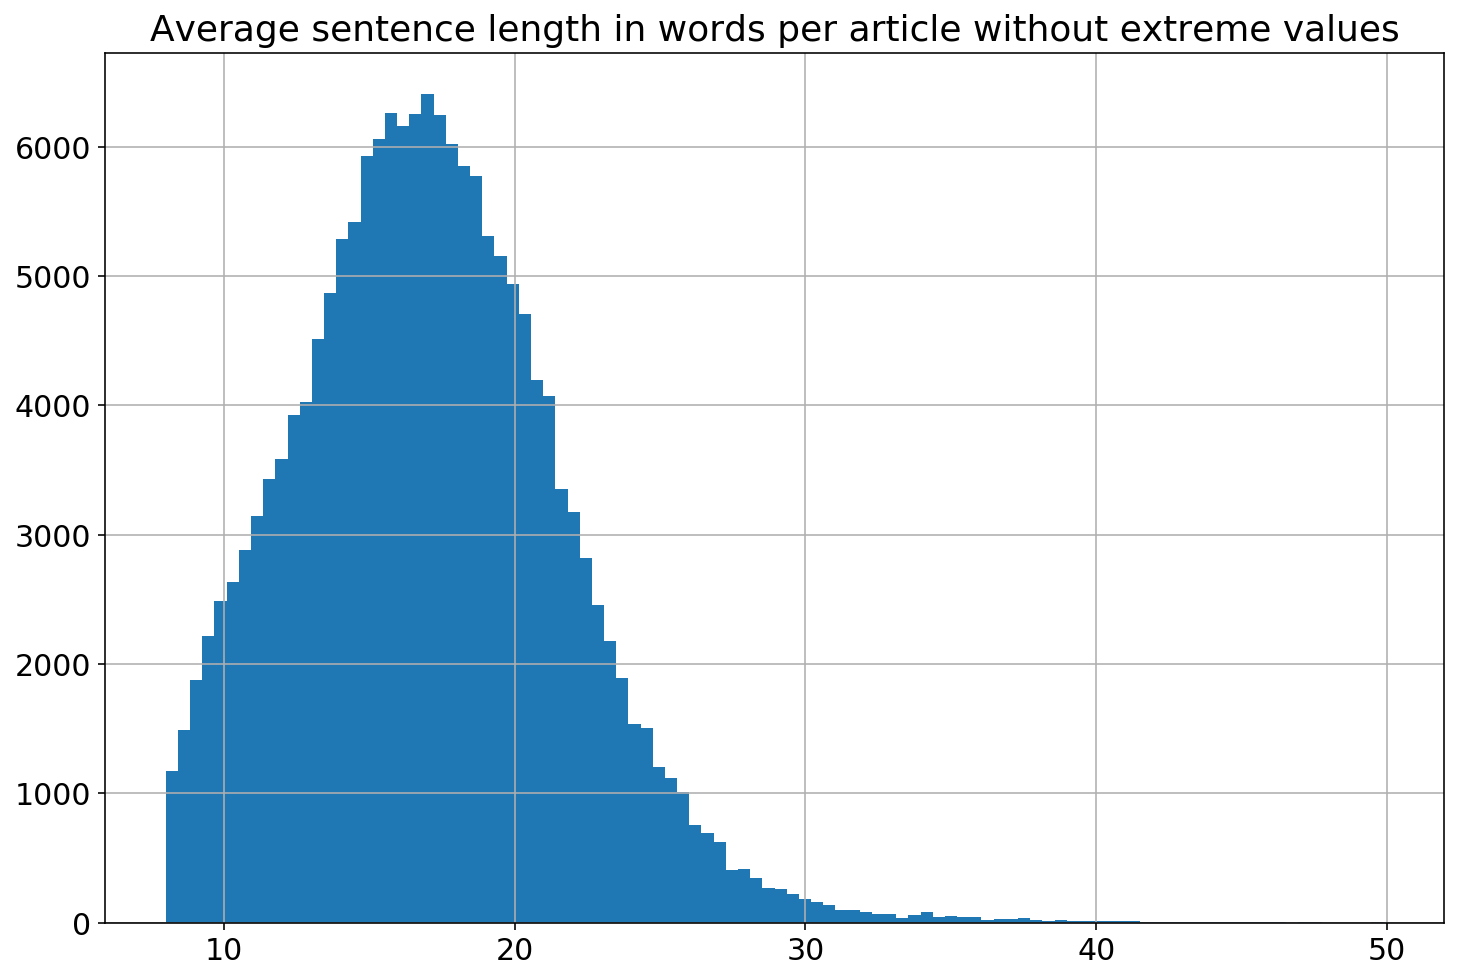

In [47]:
df.hist(column='avg_sentence_length', bins=100, figsize=(12,8))
plt.title('Average sentence length in words per article without extreme values');

As we can see, after removing extreme values, distribution of average sentence lenght meet statement mentioned above (Common plain English guideline). 

### Language distribution in articles

In [48]:
df['language'] = df['body'].apply(lambda x: lang_detect(x))

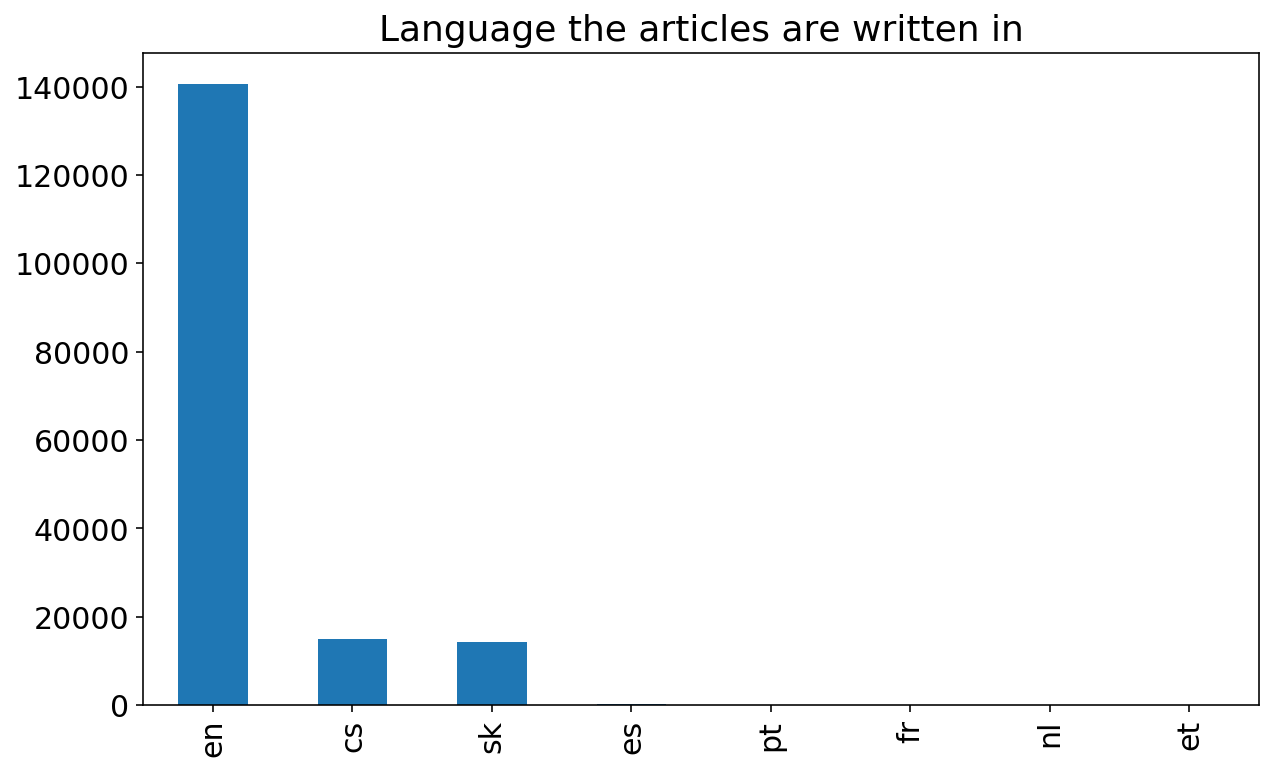

In [49]:
pd.value_counts(df['language']).plot.bar()
plt.title('Language the articles are written in');

Most articles are written in english, so we will use only those for training our model.

In [50]:
len(df)

170054

In [51]:
df = df.loc[df['language'] == 'en']

In [52]:
len(df)

140623

### WordCloud

Let's look at the most used words in articles:


In [53]:
plt.rcParams['figure.figsize'] = (30, 20)

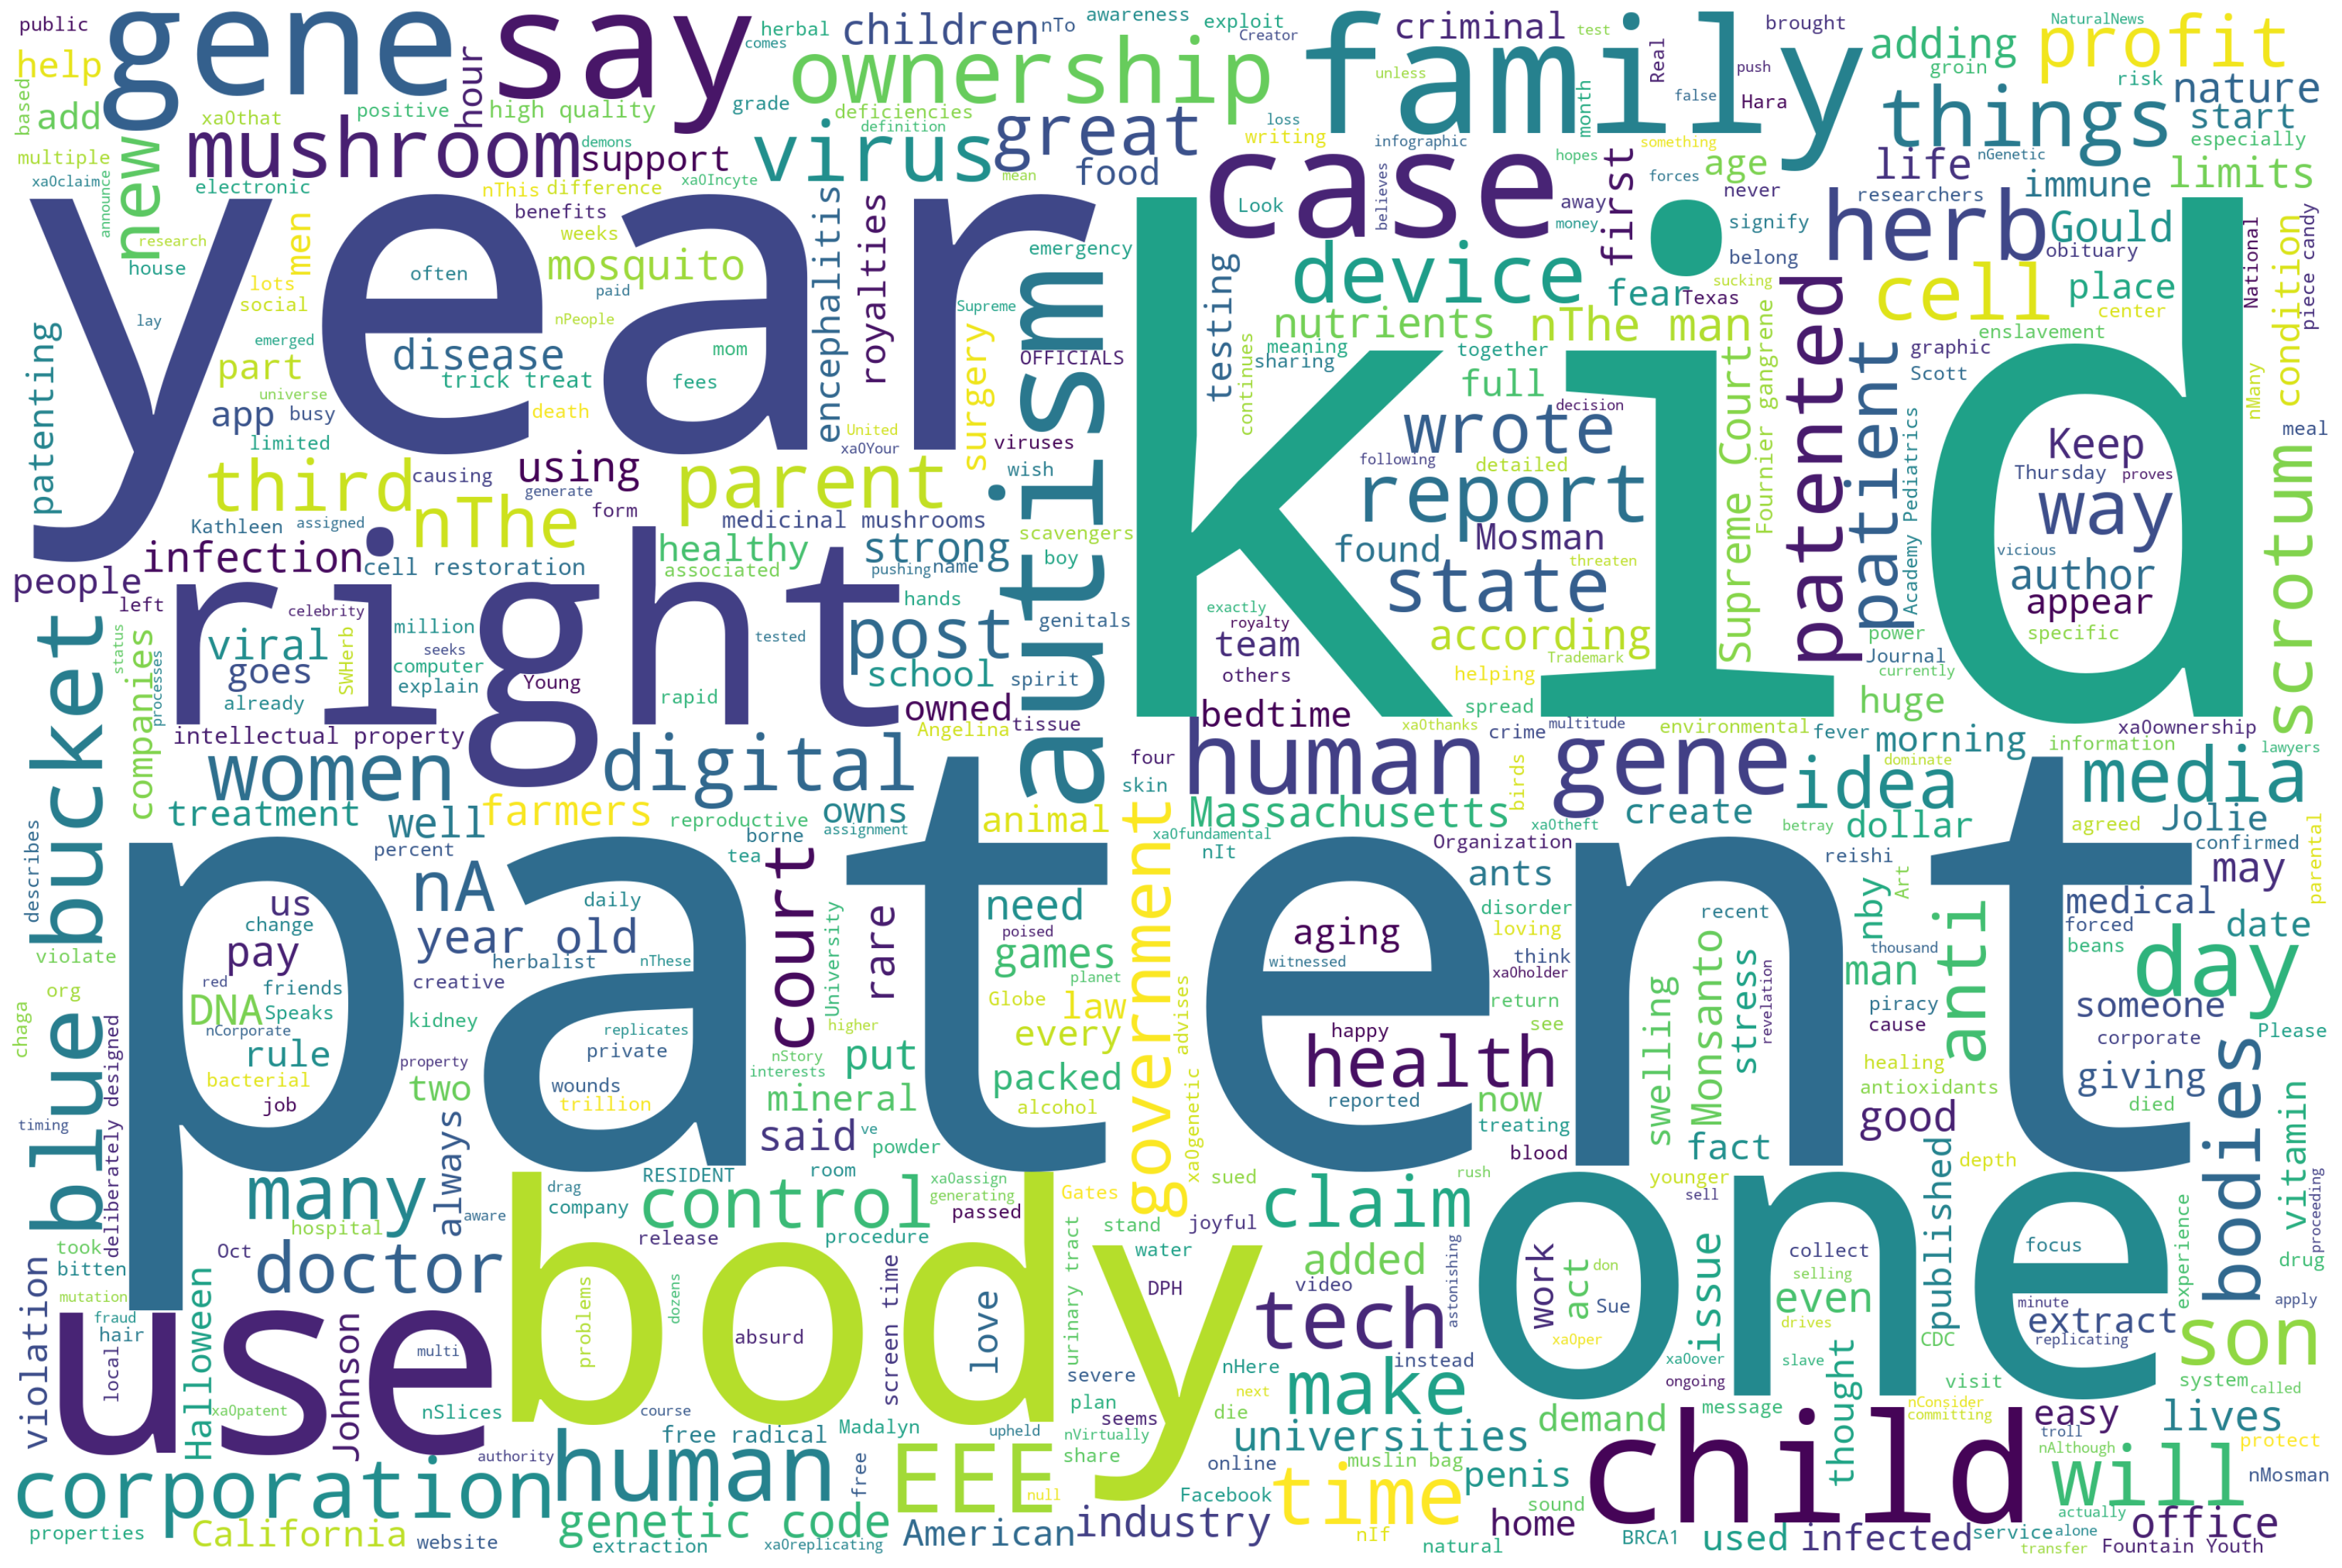

In [54]:
# max_font_size, max_words 100
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df.body.values
wordcloud = WordCloud(
    max_words=500,
    width=3000,
    height=2000,
    background_color='white',
    stopwords=STOPWORDS).generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# wordcloud.to_file("wordcloud.png")

From the wordcloud above, we can see that our data contains also generic words like *body* or *year*, but also some common words for health-related fake news like *autism*, *gene* etc.

At last, let's take a look at some specific articles from sources with the highest number of articles in our dataset. These are:

In [55]:
df.source.value_counts()[:4]

naturalnews.com         20406
neurosciencenews.com    12956
statnews.com             9186
naturalnewsblogs.com     8711
Name: source, dtype: int64

In [56]:
df[df['source'] == 'naturalnews.com'].head()

,author,body,id,image,label,perex,source,title,word_count,avg_sentence_length,language
235118,Ethan Huff,\n\n\n (Natural News)\n Now that Wikipedia ha...,235118,https://www.naturalnews.com/wp-content/uploads...,unreliable,None,naturalnews.com,Sec. 230 protections need to be stripped from ...,683,27.320000,en
235122,JD Heyes,\n\n\n (Natural News)\n Because most American...,235122,https://www.naturalnews.com/wp-content/uploads...,unreliable,None,naturalnews.com,Evil tech giants planning China-style “social ...,645,25.800000,en
235125,Lance D Johnson,\n\n\n (Natural News)\n One of the greatest c...,235125,https://www.naturalnews.com/wp-content/uploads...,unreliable,None,naturalnews.com,Seaweed forests hold key to overcoming antibio...,657,16.846154,en
235126,News Editors,\n\n\n (Natural News)\n This has been a tough...,235126,https://www.naturalnews.com/wp-content/uploads...,unreliable,None,naturalnews.com,Michael Mann’s tree-ring circus,678,29.478261,en
235127,Tracey Watson,\n\n\n (Natural News)\n Mental health issues ...,235127,https://www.naturalnews.com/wp-content/uploads...,unreliable,None,naturalnews.com,Mental health issues linked to higher mortalit...,687,16.756098,en


Let's look at some articles. 

In [57]:
df.loc[235122].body[:500]

' \n\n\n (Natural News)\n Because most Americans tend to shun international news and would rather immerse themselves in sports channels and entertainment websites, they aren’t aware of China’s grand plan to use technology to exert complete control over its vast population indefinitely.\nIn 2014, the Communist government implemented what it calls a “social credit system,” which is designed to ‘score’ citizens’ behavior. According to the government, the objective beyond the nationwide system, which is d'

In [58]:
df.loc[235122].body[3000:]

'he power to remake our constitutional republic into an authoritarian nightmare our founders could never have fathomed (let alone tolerated).\nBokhari noted that in China’s case, the government will likely use its social credit system to punish the hundreds of thousands of people who are taking part in protests in Hong Kong — which are turning violent and which Beijing is determined to quell one way or another.\xa0\n“There were queues at train stations by concerned members of those [Hong Kong] protests who were worried that they’ve been banned from transport for protesting against the government,” Bokhari said. “We’re not at that level yet, but Uber, like I said, has started banning people for their political viewpoints.”\nAnd once those bans get to the level of what Facebook, Google, YouTube and Twitter are doing to conservatives, “they will start banning people for attending the ‘wrong’ political rallies,” he added. “It’s not hard to see that happening.\n\nSources include:\nBreitbart

After checking some articles from this source, we found out that almost every article begins with *(Natural News)* and many of them end with sentence *Sources include:* followed by list of urls used as sources for given article. Because it was common for many articles (approximately 6000) we decided to remove these sentences in preprocessing.

In [59]:
df[df['source'] == 'naturalnewsblogs.com'].head()

,author,body,id,image,label,perex,source,title,word_count,avg_sentence_length,language
235036,Mike Adams,(NaturalNews) The United States government cla...,235036,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,<p>(NaturalNews) The United States government ...,naturalnewsblogs.com,US government claims 100% ownership over all y...,982,19.640000,en
235039,Mike Adams,(NaturalNews) Beyond merely inspiring women to...,235039,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,<p>(NaturalNews) Beyond merely inspiring women...,naturalnewsblogs.com,Angelina Jolie copied by men! Surgeons now cut...,1280,15.058824,en
235041,Mike Adams,"(NaturalNews) As Natural News readers know, we...",235041,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,"<p>(NaturalNews) As Natural News readers know,...",naturalnewsblogs.com,Natural News releases latest laboratory test r...,1519,13.809091,en
235043,Mike Adams,"(NaturalNews) Late last week, a story broke th...",235043,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,"<p>(NaturalNews) Late last week, a story broke...",naturalnewsblogs.com,Toxic shock: California allows up to one thous...,1103,22.060000,en
235046,Mike Adams,(NaturalNews) I’m reaching out to you all with...,235046,https://www.naturalnewsblogs.com/wp-content/up...,unreliable,<p>(NaturalNews) I&#8217;m reaching out to you...,naturalnewsblogs.com,The fall of reason: How to protect your sanity...,2649,18.524476,en


In [60]:
df.loc[235036].body[:500]

'(NaturalNews) The United States government claims 100% ownership over all your DNA and reproductive rights. This astonishing revelation has emerged from the fact that the U.S. Patent and Trademark Office claims the power to\xa0assign\xa0ownership of your DNA to private companies and universities who apply for patents on your genes.\nTo date, more than 4,000 genes have been assigned ownership to corporations and universities by the U.S. patent office. Such an assignment of ownership proves that the gove'

We can see repeating pattern there: *(NaturalNews)* at the begining of almost every article. We handled this situation above and there aren't anything specific in rest of the articles, so we can move to next source. 

In [61]:
df[df['source'] == 'neurosciencenews.com'].head()

,author,body,id,image,label,perex,source,title,word_count,avg_sentence_length,language
278512,Neuroscience News Posts Science Research News ...,Summary: When a motor neuron-specific pool of ...,278512,https://i1.wp.com/neurosciencenews.com/files/2...,reliable,"<a href=""https://neurosciencenews.com/motor-ne...",neurosciencenews.com,New insight into motor neuron death mechanisms...,916,20.818182,en
278514,Neuroscience News Posts Science Research News ...,"Summary: Researchers say serotonin, a chemical...",278514,https://i2.wp.com/neurosciencenews.com/files/2...,reliable,"<a href=""https://neurosciencenews.com/serotoni...",neurosciencenews.com,Serotonin may be a biomarker for breathing int...,964,16.338983,en
278515,Neuroscience News Posts Science Research News ...,Summary: Artificial intelligence systems that ...,278515,https://i2.wp.com/neurosciencenews.com/files/2...,reliable,"<a href=""https://neurosciencenews.com/ai-lie-d...",neurosciencenews.com,Can AI spot liars?,824,17.913043,en
278517,Neuroscience News Posts Science Research News ...,Summary: Parents who communicate with their in...,278517,https://i2.wp.com/neurosciencenews.com/files/2...,reliable,"<a href=""https://neurosciencenews.com/autism-i...",neurosciencenews.com,Autism study stresses importance of communicat...,1201,17.925373,en
278519,Neuroscience News Posts Science Research News ...,Summary: Researchers have developed a sensor-i...,278519,https://i2.wp.com/neurosciencenews.com/files/2...,reliable,"<a href=""https://neurosciencenews.com/electron...",neurosciencenews.com,Electronic glove offers ‘humanlike’ features f...,839,20.463415,en


In [62]:
df.loc[278514].body[5000:]

'zure for measurement of serum 5-HT levels. Seizures were classified according to the International League Against Epilepsy 2017 seizure classification. We analyzed seizures with and without ICA (n = 49) and generalized convulsive seizures (GCS) with and without PCCA (n = 27).\n\nResults\n\nPostictal serum 5-HT levels were increased over interictal levels for seizures without ICA (p = 0.01), compared to seizures with ICA (p = 0.21). In patients with GCS without PCCA, serum 5-HT levels were increased postictally compared to interictal levels (p < 0.001), but not in patients with seizures with PCCA (p = 0.22). Postictal minus interictal 5-HT levels also differed between the 2 groups with and without PCCA (p = 0.03). Increased heart rate was accompanied by increased serum 5-HT levels (postictal minus interictal) after seizures without PCCA (p = 0.03) compared to those with PCCA (p = 0.42).\n\nConclusions\n\nThe data suggest that significant seizure-related increases in serum 5-HT levels a

In every article from this source we encountered sentence *Feel free to share this Neuroscience News*, so we will also take care of it during preprocessing. 

In [63]:
df[df['source'] == 'statnews.com'].head()

,author,body,id,image,label,perex,source,title,word_count,avg_sentence_length,language
259950,Ed Silverman Matthew Herper,"Rise and shine, everyone, another busy day is ...",259950,https://www.statnews.com/wp-content/uploads/20...,reliable,Purdue Pharma may seek bankruptcy protection b...,statnews.com,Pharmalittle: Judge rules drug makers must fac...,181,18.100000,en
259951,Rebecca Robbins Diana Cai Sharon Begley Associ...,Two versions of a video of the same moment in ...,259951,https://www.statnews.com/wp-content/uploads/20...,reliable,A new imaging restoration technique using deep...,statnews.com,Deep-learning AI helps scientists see more cle...,991,21.085106,en
259952,Megan Thielking Casey Ross Rebecca Robbins,Bob Coughlin (right) and Kendalle Burlin O'Con...,259952,https://www.statnews.com/wp-content/uploads/20...,reliable,They’re hoping to turn Boston into a digital h...,statnews.com,Can MassBio turn Boston into a hub for digital...,135,13.500000,en
259953,Gail Mcintyre Matthew Herder Matthew R. Bailey...,Enough with the me-too drugs. New treatments s...,259953,https://www.statnews.com/wp-content/uploads/20...,reliable,Drug developers should should treat patients w...,statnews.com,Enough with the me-too drugs in cancer clinica...,852,18.933333,en
259955,Adam Feuerstein Jonathan Saltzman Boston Globe...,The Food and Drug Administration is bringing t...,259955,https://www.statnews.com/wp-content/uploads/20...,reliable,"Ahead of a pivotal FDA meeting, here are seven...",statnews.com,What to know before key FDA meeting on Aimmune...,109,36.333333,en


In [64]:
df.loc[259951].body[1500:2500]

"a preprint server.\n\nWhat issue did you set out to address?\n\nWhen scientists want to get a high-resolution view of mitochondria dividing, they often shine a powerful laser upon the cell. But that laser power causes cells to become stressed, and mitochondria divide in response to that stress — a phenomenon known as phototoxicity-induced fission.\n\nNewsletters Sign up for STAT Health Tech Your weekly guide to how tech is transforming health care and life sciences. Please enter a valid email address. Leave this field empty if you're human:\n\nThat’s a problem, because scientists want to see how mitochondria divide under normal conditions, not ones created by research. Scientists have long tried to get around that by using much lower image quality, but that approach creates its own problems because it makes it harder to detect the fission, or to see it with as much detail.\n\nManor said he and his team wanted “the best of both worlds” — low phototoxicity and high image quality. So the

Specific sentences for articles from this source are *Please enter a valid email address. Leave this field empty if you're human*. We will remove these too, as they are occuring in almost every one of them. 

During this analysis, we noticed that many articles contain the possibility to subscribe to the newsletter represented by phrases like *sign up*, *sign up to our newsletter*, or simply words *newsletter*/*newsletters*. As they are commonly repeated across many of them, we decided to remove these keywords as well.  

### Conclusion

Problems found during analysis and solutions:
* some articles contains lot of junk data - many urls, CDATA sections
    * remove these sections from articles without losing valuable data
* duplicates of some articles
    * remove those completely
* extreme values in number of words per article
    * set treshold for shortest and longest article
* extreme values in average number of words per article 
    * keep only articles in interval from 8 to 50 
* specific sentences and phrases repeating in articles from some sources
    * remove these sentences or phrases from articles
    
After applying these solutions during preprocessing, the dataset with clean data will be ready for further use in training.